## Group No : 22

## Group Member Names:
1. 
2.
3.Sudipto Das (2022aa05217)
4. 

## Journal used for the implemetation
Journal title:

Authors:

Journal Name:

Year:

## Note to the evaluator ##
<ol>
    <li>Affectnet is pretty big dataset,The model in the paper was originally trained on gpu  </li>
<li>However due to lack of computational resources to the group we had to settle for 
smaller subset of the data and fewer epochs </li>
<li>Safe to say the model is not trained completely and hence efficiency is 
not aligned with that of the papaer's </li>
<li>However, this is a mere attempt to replicate a scholarly article and implement the 
logic as understood from the papaer  </li>
</ol>

# 1. Import the required libraries

In [1]:
##---------Type the code below this line------------------##
import os
import sys
import glob
from tqdm import tqdm
import argparse

from PIL import Image
import numpy as np
import pandas as pd
from torchvision import models

import torch
import torch.nn as nn
import torch.utils.data as data
from torchvision import transforms, datasets
import torch.nn.init as init
from torch.nn import functional as F
from torch.utils.data import Dataset, DataLoader, random_split, SubsetRandomSampler, WeightedRandomSampler

In [2]:
import sys
sys.argv = ['']

# 2. Data Acquisition
 
For the problem identified by you, students have to find the data source themselves from any data source.

Provide the URL of the data used.

Write Code for converting the above downloaded data into a form suitable for DL



In [3]:
##---------Type the code below this line------------------##

<a href=http://mohammadmahoor.com/affectnet/>Data url for AffectNet</a>

## Run this code for data splitting and CSV generation only else leave commented out 

In [4]:
# import shutil
# import os
# import numpy as np
# import argparse

# def get_files_from_folder(path):

#     files = os.listdir(path)
#     return np.asarray(files)

# def main(path_to_data, path_to_test_data, train_ratio):
#     # get dirs
#     _, dirs, _ = next(os.walk(path_to_data))

#     # calculates how many train data per class
#     data_counter_per_class = np.zeros((len(dirs)))
#     for i in range(len(dirs)):
#         path = os.path.join(path_to_data, dirs[i])
#         files = get_files_from_folder(path)
#         data_counter_per_class[i] = len(files)
#     test_counter = np.round(data_counter_per_class * (1 - train_ratio))

#     # transfers files
#     for i in range(len(dirs)):
#         path_to_original = os.path.join(path_to_data, dirs[i])
#         path_to_save = os.path.join(path_to_test_data, dirs[i])

#         #creates dir
#         if not os.path.exists(path_to_save):
#             os.makedirs(path_to_save)
#         files = get_files_from_folder(path_to_original)
#         # moves data
#         for j in range(int(test_counter[i])):
#             dst = os.path.join(path_to_save, files[j])
#             src = os.path.join(path_to_original, files[j])
#             shutil.move(src, dst)


# def parse_args():
#   parser = argparse.ArgumentParser(description="Dataset divider")
#   parser.add_argument("--data_path", required=True,
#     help="Path to data")
#   parser.add_argument("--test_data_path_to_save", required=True,
#     help="Path to test data where to save")
#   parser.add_argument("--train_ratio", required=True,
#     help="Train ratio - 0.7 means splitting data in 70 % train and 30 % test")
#   return parser.parse_args()

# # if __name__ == "__main__":
# #   args = parse_args()
# data_path = "./datasets/AfectNet/"
# main(data_path, data_path+'val_set/', 0.990)

## CSV generation 

In [5]:
# data = pd.read_csv("./datasets/AfectNet/temp/labels.csv")
# df=data[['Unnamed: 0','pth', 'label', 'relFCs']].groupby('label').head(100)
# df.to_csv('./datasets/AfectNet/train.csv')

# 3. Data Preparation

Perform the data prepracessing that is required for the data that you have downloaded. 


This stage depends on the dataset that is used. 

In [6]:
##---------Type the code below this line------------------##

## Split the data into training set and testing set
##---------Type the code below this line------------------##

## Identify the target variables.
##---------Type the code below this line------------------##


In [7]:
eps = sys.float_info.epsilon

def parse_args():
    parser = argparse.ArgumentParser()
    parser.add_argument('--aff_path', type=str, default='./datasets/AfectNet/', help='AfectNet dataset path.')
    parser.add_argument('--batch_size', type=int, default=256, help='Batch size.')
    parser.add_argument('--lr', type=float, default=0.0001, help='Initial learning rate for adam.')
    parser.add_argument('--workers', default=8, type=int, help='Number of data loading workers.')
    parser.add_argument('--epochs', type=int, default=4, help='Total training epochs.')
    parser.add_argument('--num_head', type=int, default=4, help='Number of attention head.')
    parser.add_argument('--num_class', type=int, default=8, help='Number of class.')

    return parser.parse_args()

In [8]:
class DAN(nn.Module):
    def __init__(self, num_class=7,num_head=4, pretrained=True):
        super(DAN, self).__init__()
        
        resnet = models.resnet18(pretrained)
        
        if pretrained:
            print("pretrained",pretrained)
            checkpoint = torch.load('./models/resnet18_msceleb.pth',map_location=torch.device('cpu'))
            resnet.load_state_dict(checkpoint['state_dict'],strict=True)

        self.features = nn.Sequential(*list(resnet.children())[:-2])
        self.num_head = num_head
        for i in range(num_head):
            setattr(self,"cat_head%d" %i, CrossAttentionHead())
        self.sig = nn.Sigmoid()
        self.fc = nn.Linear(512, num_class)
        self.bn = nn.BatchNorm1d(num_class)


    def forward(self, x):
        x = self.features(x)
        heads = []
        for i in range(self.num_head):
            heads.append(getattr(self,"cat_head%d" %i)(x))
        
        heads = torch.stack(heads).permute([1,0,2])
        if heads.size(1)>1:
            heads = F.log_softmax(heads,dim=1)
            
        out = self.fc(heads.sum(dim=1))
        out = self.bn(out)
        print("out, x, heads",out, x, heads)
        return out, x, heads

In [9]:
class SpatialAttention(nn.Module):

    def __init__(self):
        super().__init__()
        self.conv1x1 = nn.Sequential(
            nn.Conv2d(512, 256, kernel_size=1),
            nn.BatchNorm2d(256),
        )
        self.conv_3x3 = nn.Sequential(
            nn.Conv2d(256, 512, kernel_size=3,padding=1),
            nn.BatchNorm2d(512),
        )
        self.conv_1x3 = nn.Sequential(
            nn.Conv2d(256, 512, kernel_size=(1,3),padding=(0,1)),
            nn.BatchNorm2d(512),
        )
        self.conv_3x1 = nn.Sequential(
            nn.Conv2d(256, 512, kernel_size=(3,1),padding=(1,0)),
            nn.BatchNorm2d(512),
        )
        self.relu = nn.ReLU()


    def forward(self, x):
        y = self.conv1x1(x)
        y = self.relu(self.conv_3x3(y) + self.conv_1x3(y) + self.conv_3x1(y))
        y = y.sum(dim=1,keepdim=True) 
        out = x*y
        
        return out 

In [10]:
class ChannelAttention(nn.Module):

    def __init__(self):
        super().__init__()
        self.gap = nn.AdaptiveAvgPool2d(1)
        self.attention = nn.Sequential(
            nn.Linear(512, 32),
            nn.BatchNorm1d(32),
            nn.ReLU(inplace=True),
            nn.Linear(32, 512),
            nn.Sigmoid()    
        )


    def forward(self, sa):
        sa = self.gap(sa)
        sa = sa.view(sa.size(0),-1)
        y = self.attention(sa)
        out = sa * y
        
        return out

In [11]:
class CrossAttentionHead(nn.Module):
    def __init__(self):
        super().__init__()
        self.sa = SpatialAttention()
        self.ca = ChannelAttention()
        self.init_weights()


    def init_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                init.kaiming_normal_(m.weight, mode='fan_out')
                if m.bias is not None:
                    init.constant_(m.bias, 0)
            elif isinstance(m, nn.BatchNorm2d):
                init.constant_(m.weight, 1)
                init.constant_(m.bias, 0)
            elif isinstance(m, nn.Linear):
                init.normal_(m.weight, std=0.001)
                if m.bias is not None:
                    init.constant_(m.bias, 0)
    def forward(self, x):
        sa = self.sa(x)
        ca = self.ca(sa)

        return ca

In [12]:
class AffectNet(data.Dataset):
    def __init__(self, aff_path, phase, use_cache = True, transform = None):
        self.phase = phase
        self.transform = transform
        self.aff_path = aff_path
        
        if use_cache:
            cache_path = os.path.join(aff_path,'affectnet.csv')
            if os.path.exists(cache_path):
                df = pd.read_csv(cache_path)
            else:
                df = self.get_df()
                df.to_csv(cache_path)
        else:
            df = self.get_df()

        self.data = df[df['phase'] == phase]

        self.file_paths = self.data.loc[:, 'img_path'].values
        self.label = self.data.loc[:, 'label'].values

        _, self.sample_counts = np.unique(self.label, return_counts=True)
        # print(f' distribution of {phase} samples: {self.sample_counts}')

    def get_df(self):
        train_path = os.path.join(self.aff_path,'train_set/')
        val_path = os.path.join(self.aff_path,'val_set/')
        data = []
        
        for anno in glob.glob(train_path + 'annotations/*_exp.npy'):
            idx = os.path.basename(anno).split('_')[0]
            img_path = os.path.join(train_path,f'images/{idx}.jpg')
            label = int(np.load(anno))
            data.append(['train',img_path,label])
        
        for anno in glob.glob(val_path + 'annotations/*_exp.npy'):
            idx = os.path.basename(anno).split('_')[0]
            img_path = os.path.join(val_path,f'images/{idx}.jpg')
            label = int(np.load(anno))
            data.append(['val',img_path,label])
        
        return pd.DataFrame(data = data,columns = ['phase','img_path','label'])

    def __len__(self):
        return len(self.file_paths)

    def __getitem__(self, idx):
        path = self.file_paths[idx]
        image = Image.open(path).convert('RGB')
        label = self.label[idx]

        if self.transform is not None:
            image = self.transform(image)
        
        return image, label

In [13]:
class AffinityLoss(nn.Module):
    def __init__(self, device, num_class=8, feat_dim=512):
        super(AffinityLoss, self).__init__()
        self.num_class = num_class
        self.feat_dim = feat_dim
        self.gap = nn.AdaptiveAvgPool2d(1)
        self.device = device

        self.centers = nn.Parameter(torch.randn(self.num_class, self.feat_dim).to(device))

    def forward(self, x, labels):
        x = self.gap(x).view(x.size(0), -1)

        batch_size = x.size(0)
        distmat = torch.pow(x, 2).sum(dim=1, keepdim=True).expand(batch_size, self.num_class) + \
                  torch.pow(self.centers, 2).sum(dim=1, keepdim=True).expand(self.num_class, batch_size).t()
        distmat.addmm_(x, self.centers.t(), beta=1, alpha=-2)

        classes = torch.arange(self.num_class).long().to(self.device)
        labels = labels.unsqueeze(1).expand(batch_size, self.num_class)
        mask = labels.eq(classes.expand(batch_size, self.num_class))

        dist = distmat * mask.float()
        dist = dist / self.centers.var(dim=0).sum()

        loss = dist.clamp(min=1e-12, max=1e+12).sum() / batch_size

        return loss

In [14]:
class PartitionLoss(nn.Module):
    def __init__(self, ):
        super(PartitionLoss, self).__init__()
    
    def forward(self, x):
        num_head = x.size(1)

        if num_head > 1:
            var = x.var(dim=1).mean()
            ## add eps to avoid empty var case
            loss = torch.log(1+num_head/(var+eps))
        else:
            loss = 0
            
        return loss

In [15]:
class ImbalancedDatasetSampler(data.sampler.Sampler):
    def __init__(self, dataset, indices: list = None, num_samples: int = None):
        self.indices = list(range(len(dataset))) if indices is None else indices
        self.num_samples = len(self.indices) if num_samples is None else num_samples

        df = pd.DataFrame()
        df["label"] = self._get_labels(dataset)
        df.index = self.indices
        df = df.sort_index()

        label_to_count = df["label"].value_counts()

        weights = 1.0 / label_to_count[df["label"]]

        self.weights = torch.DoubleTensor(weights.to_list())

        # self.weights = self.weights.clamp(min=1e-5)

    def _get_labels(self, dataset):
        if isinstance(dataset, datasets.ImageFolder):
            return [x[1] for x in dataset.imgs]
        elif isinstance(dataset, torch.utils.data.Subset):
            return [dataset.dataset.imgs[i][1] for i in dataset.indices]
        else:
            raise NotImplementedError

    def __iter__(self):
        return (self.indices[i] for i in torch.multinomial(self.weights, self.num_samples, replacement=True))

    def __len__(self):
        return self.num_samples

## 4. Deep Neural Network Architecture


## 4.1 Design the architecture that you will be using

* CNN / RNN / Transformer as per the journal referenced



In [16]:
##---------Type the code below this line------------------##

In [17]:
args = parse_args()
data_transforms_val = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                             std=[0.229, 0.224, 0.225])]) 

In [18]:
model1 = DAN(num_class=args.num_class, num_head=args.num_head)
checkpoint = torch.load('./datasets/checkpoints/affecnet8_epoch4_acc0.0882.pth')
model1.load_state_dict(checkpoint["model_state_dict"])

C:\Users\sudip\anaconda3\envs\tf1\lib\site-packages\torchvision\models\_utils.py:135: UserWarning: Using 'weights' as positional parameter(s) is deprecated since 0.13 and may be removed in the future. Please use keyword parameter(s) instead.
  warnings.warn(
C:\Users\sudip\anaconda3\envs\tf1\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


pretrained True


<All keys matched successfully>

In [19]:
model1

DAN(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  

## 4.2 DNN Report

Report the following and provide justification for the same.

* Number of layers
* Number of units in each layer
* Total number of trainable parameters 



In [20]:
model1

DAN(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  

# 5. Training the model 


In [21]:
# Configure the training, by using appropriate optimizers, regularizations and loss functions
##---------Type the code below this line------------------##

In [22]:
training_loss=[]
training_accuracy=[]
validation_loss=[]
validation_accuracy=[]

def run_training():
    args = parse_args()

    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

    if torch.cuda.is_available():
        torch.backends.cudnn.benchmark = True
        torch.backends.cudnn.deterministic = True
        torch.backends.cudnn.enabled = True
    print("args.num_class",args.num_class)

    model = DAN(num_class=args.num_class, num_head=args.num_head)
    model.to(device)

        
    data_transforms = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.RandomHorizontalFlip(),
        transforms.RandomApply([
                transforms.RandomAffine(20, scale=(0.8, 1), translate=(0.2, 0.2)),
            ], p=0.7),

        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225]),
        transforms.RandomErasing(),
        ])
    print("f'{args.aff_path}val_set/'",f'{args.aff_path}val_set/')
#     train_dataset = AffectNet(args.aff_path, phase = 'train', transform = data_transforms)   # loading dynamically
# f'{args.aff_path}/train'
    
#     ---------------------------------------------
#     whole = datasets.ImageFolder(root = f'{args.aff_path}')
#     dataset_size = whole.__len__()
#     indices = list(range(dataset_size))
#     validation_split = 0.7
#     split = int(np.floor(validation_split * dataset_size))
#     if 1 :
#         np.random.seed(1337)
#         np.random.shuffle(indices)
#     train_indices, valid_indices = indices[split*2:], indices[:split]
#     train_sampler = SubsetRandomSampler(train_indices)
#     valid_sampler = SubsetRandomSampler(valid_indices)
#     print("valid_sampler",valid_sampler)
# --------------------------------------------------------
    
    train_dataset = datasets.ImageFolder(f'{args.aff_path}train_set/', transform = data_transforms)   # loading statically
    if args.num_class == 7:   # ignore the 8-th class
        idx = [i for i in range(len(train_dataset)) if train_dataset.imgs[i][1] != 7]
        train_dataset = data.Subset(train_dataset, idx)

    print('Whole train set size:', train_dataset.__len__())
    train_loader = torch.utils.data.DataLoader(train_dataset,
                                               batch_size = args.batch_size,
#                                                num_workers = args.workers,
                                               num_workers = 0,
                                               sampler=ImbalancedDatasetSampler(train_dataset),
                                               shuffle = False, 
                                               pin_memory = True,)

    data_transforms_val = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225])])      
                                                                      
#     val_dataset = AffectNet(args.aff_path, phase = 'val', transform = data_transforms_val)  # loading dynamically

    val_dataset = datasets.ImageFolder(f'{args.aff_path}val_set/', transform = data_transforms_val)    # loading statically
    if args.num_class == 7:   # ignore the 8-th class 
        idx = [i for i in range(len(val_dataset)) if val_dataset.imgs[i][1] != 7]
        val_dataset = data.Subset(val_dataset, idx)

    print('Validation set size:', val_dataset.__len__())
    
    val_loader = torch.utils.data.DataLoader(val_dataset,
                                               batch_size = args.batch_size,
#                                                num_workers = args.workers,
                                             num_workers = 0,
                                               shuffle = False,  
                                               pin_memory = True)


    criterion_cls = torch.nn.CrossEntropyLoss().to(device)
    criterion_af = AffinityLoss(device, num_class=args.num_class)
    criterion_pt = PartitionLoss()

    params = list(model.parameters()) + list(criterion_af.parameters())
    optimizer = torch.optim.Adam(params,args.lr,weight_decay = 0)
    scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma = 0.6)

    
    best_acc = 0
    for epoch in tqdm(range(1, args.epochs + 1)):
        running_loss = 0.0
        correct_sum = 0
        iter_cnt = 0
        model.train()

        for (imgs, targets) in train_loader:
            iter_cnt += 1
            optimizer.zero_grad()

            imgs = imgs.to(device)
            targets = targets.to(device)
            
            out,feat,heads = model(imgs)

            loss = criterion_cls(out,targets) + criterion_af(feat,targets) + criterion_pt(heads)

            loss.backward()
            optimizer.step()
            
            running_loss += loss
            _, predicts = torch.max(out, 1)
            correct_num = torch.eq(predicts, targets).sum()
            correct_sum += correct_num

        acc = correct_sum.float() / float(train_dataset.__len__())
        running_loss = running_loss/iter_cnt
        tqdm.write('[Epoch %d] Training accuracy: %.4f. Loss: %.3f. LR %.6f' 
                   % (epoch, acc, running_loss,optimizer.param_groups[0]['lr']))
        training_loss.append(running_loss.detach().cpu().numpy().tolist())
        training_accuracy.append(acc.detach().cpu().numpy().tolist())
        
        
        with torch.no_grad():
            running_loss = 0.0
            iter_cnt = 0
            bingo_cnt = 0
            sample_cnt = 0
            model.eval()
            for imgs, targets in val_loader:
        
                imgs = imgs.to(device)
                targets = targets.to(device)
                out,feat,heads = model(imgs)

                loss = criterion_cls(out,targets) + criterion_af(feat,targets) + criterion_pt(heads)

                running_loss += loss
                iter_cnt+=1
                _, predicts = torch.max(out, 1)
                correct_num  = torch.eq(predicts,targets)
                bingo_cnt += correct_num.sum().cpu()
                sample_cnt += out.size(0)
                
            running_loss = running_loss/iter_cnt   
            scheduler.step()

            acc = bingo_cnt.float()/float(sample_cnt)
            acc = np.around(acc.numpy(),4)
            best_acc = max(acc,best_acc)
            tqdm.write("[Epoch %d] Validation accuracy:%.4f. Loss:%.3f" % (epoch, acc, running_loss))
            validation_loss.append(running_loss.detach().cpu().numpy().tolist())
            validation_accuracy.append(acc)
            tqdm.write("best_acc:" + str(best_acc))

#             if args.num_class == 7 and  acc > 0.65:
#                 torch.save({'iter': epoch,
#                             'model_state_dict': model.state_dict(),
#                              'optimizer_state_dict': optimizer.state_dict(),},
#                             os.path.join('checkpoints', "affecnet7_epoch"+str(epoch)+"_acc"+str(acc)+".pth"))
#                 tqdm.write('Model saved.')

#             elif args.num_class == 8 and  acc > 0.62:
#                 torch.save({'iter': epoch,
#                             'model_state_dict': model.state_dict(),
#                              'optimizer_state_dict': optimizer.state_dict(),},
#                             os.path.join('checkpoints', "affecnet8_epoch"+str(epoch)+"_acc"+str(acc)+".pth"))
#                 tqdm.write('Model saved.')
#             print("epoch",epoch ,"model.state_dict()",model.state_dict(), "affecnet8_epoch"+str(epoch)+"_acc"+str(acc)+".pth")
#             torch.save({'iter': epoch,
#             'model_state_dict': model.state_dict(),
#              'optimizer_state_dict': optimizer.state_dict(),},
#             os.path.join('./datasets/checkpoints/', "affecnet8_epoch"+str(epoch)+"_acc"+str(acc)+".pth"))
#             tqdm.write('Model saved.')

In [23]:
run_training()

args.num_class 8
pretrained True
f'{args.aff_path}val_set/' ./datasets/AfectNet/val_set/
Whole train set size: 103
Validation set size: 102


  0%|                                                                                            | 0/4 [00:00<?, ?it/s]

out, x, heads tensor([[ 2.3097e-01, -1.0584e+00,  2.4674e+00, -1.1229e+00, -9.0914e-01,
         -1.0234e+00,  1.9206e-01, -1.4284e+00],
        [ 7.0668e-01, -4.3463e-01,  7.2986e-01, -3.3454e-01, -1.6202e-01,
          4.8885e-03, -1.5429e-01,  4.5269e-01],
        [-4.4174e-01,  1.2353e-02, -9.4560e-01, -7.4323e-01,  7.9813e-01,
         -1.0813e+00, -9.8620e-02,  2.8950e-01],
        [-5.0652e-01, -6.9328e-02, -7.3679e-01,  1.1687e+00,  9.1380e-01,
         -2.3542e-01,  2.6708e-01,  1.2631e-01],
        [-3.4855e-01, -1.9812e-03,  2.9414e-02, -4.7873e-01,  9.4982e-03,
          3.2158e-01, -6.7083e-01,  8.3678e-01],
        [-2.5823e+00,  2.7750e+00,  3.8395e-01,  1.3227e+00,  7.3501e-01,
         -1.0811e+00, -3.6500e-01,  1.1765e+00],
        [-1.3343e-01, -2.7494e-01,  2.4707e-01, -3.5663e-01, -2.8791e-01,
          3.7896e-01, -7.6228e-01,  1.0059e+00],
        [-3.8626e-01, -2.5021e-01,  5.3222e-01, -5.0705e-01,  4.0420e-03,
          6.4360e-02, -1.0012e+00,  7.5434e-01],
  

  0%|                                                                                            | 0/4 [01:47<?, ?it/s]

[Epoch 1] Training accuracy: 0.1165. Loss: 3.834. LR 0.000100
out, x, heads tensor([[ 2.0823e+00,  1.8164e+00, -7.3957e+00,  5.0305e+00, -7.5705e-01,
         -3.8637e+00,  1.2537e+01, -2.4651e+00],
        [ 9.9948e-01, -7.7465e-01,  3.8216e-01,  7.6692e+00, -3.3998e-01,
         -3.5074e+00,  6.6326e+00,  4.5960e-01],
        [ 3.4220e+00,  8.6195e+00,  1.0747e+00,  3.5545e+00, -1.0231e+01,
         -1.2556e+00,  1.0212e+01, -6.8929e+00],
        [ 2.3117e+00,  1.8614e+00, -1.3699e+00, -3.3830e-01,  1.9723e+00,
          1.3421e+00,  1.1022e+01, -6.8745e+00],
        [-2.7005e+00, -1.8162e+00,  6.2163e+00,  2.8536e-01, -8.5421e-01,
          2.0692e+00,  5.4419e+00, -8.0970e+00],
        [ 5.4276e-01,  3.2369e-02,  1.7760e-01,  6.7115e+00,  1.6879e+00,
          2.0652e+00,  3.8972e+00, -2.7127e+00],
        [ 3.3260e+00,  4.0131e+00,  1.0572e+00, -2.8125e+00,  7.8444e-01,
         -4.3083e+00,  5.0612e+00, -8.4837e+00],
        [-1.4940e+00,  3.2398e+00, -2.9028e+00,  3.8526e+00, -4

 25%|████████████████████▊                                                              | 1/4 [02:02<06:08, 122.85s/it]

[Epoch 1] Validation accuracy:0.1078. Loss:9.212
best_acc:0.1078
out, x, heads tensor([[-1.7755e-01, -2.5335e-01,  1.3492e-01, -3.8486e-01,  6.3760e-02,
          3.6511e-01, -5.9932e-01,  4.6342e-01],
        [-3.3536e-01, -1.5093e-01, -1.0588e+00,  9.4317e-02, -1.1964e+00,
         -4.2363e-01,  1.1208e+00, -4.9947e-01],
        [ 9.2244e-02, -1.9835e-01,  3.0727e-01,  4.0308e-01,  2.2472e-01,
          5.0436e-02, -2.6815e-01,  1.0053e-01],
        [-1.7362e-01, -2.2838e-01, -2.2199e-01, -9.2824e-02,  1.9726e-01,
          3.4852e-01, -4.2291e-01,  5.4507e-01],
        [ 7.8658e-02,  1.3173e-01,  1.4922e+00,  8.7699e-01, -5.3919e-01,
         -4.8029e-02, -3.4885e-01,  8.2496e-02],
        [-2.1245e-01, -2.7715e-01,  2.6227e-01, -2.4616e-01,  3.8576e-01,
          4.2018e-01, -3.1165e-01,  2.2169e-01],
        [ 4.9608e+00,  2.9470e+00, -2.9385e+00, -4.6922e+00, -3.1775e+00,
         -5.6049e+00,  4.0680e+00, -4.4754e+00],
        [ 1.7320e-01, -3.9225e-01,  2.4212e-01,  1.3395e+00,

 25%|████████████████████▊                                                              | 1/4 [03:24<06:08, 122.85s/it]

[Epoch 2] Training accuracy: 0.0971. Loss: 3.549. LR 0.000060


 50%|█████████████████████████████████████████▌                                         | 2/4 [03:41<03:36, 108.32s/it]

out, x, heads tensor([[ 8.8290e-01,  1.0507e+00, -6.8421e+00,  3.0071e+00, -1.9871e+00,
         -1.8890e+00,  6.0983e+00, -6.5496e-01],
        [ 9.0095e-02, -5.0244e-01, -5.2301e-02,  5.1711e+00, -4.0999e-01,
         -3.0532e+00,  3.9168e+00,  3.4931e-01],
        [ 1.0872e+00,  4.5892e+00,  5.8099e-01,  3.8040e+00, -7.5120e+00,
         -2.0048e+00,  2.6266e+00,  6.0107e-02],
        [ 8.4733e-01,  1.6072e+00, -1.1477e+00, -8.9223e-02,  2.4973e+00,
          2.1486e-02,  6.9492e+00, -5.2582e+00],
        [-1.9297e+00, -8.1886e-01,  8.9651e+00,  1.1352e+00, -1.3558e+00,
         -3.1045e+00,  2.9228e+00, -3.6447e+00],
        [ 5.6267e-02,  1.2117e-01,  1.3328e-01,  3.0768e+00,  7.1183e-01,
          9.4494e-01,  1.0466e+00, -1.4999e+00],
        [ 1.6571e+00,  1.9713e+00,  1.0052e+00, -4.1486e+00,  8.0138e-01,
         -3.0185e+00,  3.0705e+00, -3.9701e+00],
        [-8.6564e-01,  2.3966e+00, -5.0851e+00,  5.5537e+00, -4.3450e+00,
         -5.2471e+00,  6.1002e+00,  4.1553e+00],
  

 50%|█████████████████████████████████████████▌                                         | 2/4 [04:23<03:36, 108.32s/it]

[Epoch 3] Training accuracy: 0.1942. Loss: 3.428. LR 0.000036


 75%|███████████████████████████████████████████████████████████████                     | 3/4 [04:28<01:20, 80.42s/it]

out, x, heads tensor([[ 1.0598e+00,  1.3605e+00, -3.5891e+00,  1.7784e+00, -1.8532e+00,
         -1.3791e+00,  4.9535e+00, -5.0933e-01],
        [-2.4619e-01, -3.2604e-01,  1.9186e-02,  3.9389e+00, -2.8709e-01,
         -3.2397e+00,  3.4521e+00,  2.4860e-01],
        [ 1.4824e+00,  4.3457e+00,  5.7269e-01,  4.1710e+00, -7.7818e+00,
         -3.2464e+00,  1.7885e+00,  5.5464e-01],
        [ 6.0574e-01,  1.6185e+00, -9.1471e-01, -2.3592e-01,  2.4449e+00,
         -5.0690e-01,  4.9347e+00, -4.5076e+00],
        [-1.5138e+00, -1.1862e+00,  5.1311e+00,  1.5425e+00, -5.4133e-01,
         -3.6308e+00,  2.2882e+00, -3.2159e+00],
        [ 3.4996e-02,  1.4862e-01, -5.9636e-02,  1.5899e+00,  4.0845e-01,
          6.4076e-01,  4.1763e-01, -1.0780e+00],
        [ 1.4681e+00,  1.2119e+00,  5.9111e-01, -4.0537e+00,  9.2452e-01,
         -2.4176e+00,  2.4123e+00, -3.4547e+00],
        [-3.7616e-01,  2.1361e+00, -3.5946e+00,  5.8022e+00, -3.3022e+00,
         -5.6100e+00,  5.6310e+00,  4.5575e+00],
  

 75%|███████████████████████████████████████████████████████████████                     | 3/4 [04:49<01:20, 80.42s/it]

[Epoch 4] Training accuracy: 0.2136. Loss: 3.341. LR 0.000022


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [04:54<00:00, 73.67s/it]

out, x, heads tensor([[ 1.0780e+00,  1.4616e+00, -2.9784e+00,  1.1960e+00, -1.5440e+00,
         -8.1911e-01,  4.6143e+00, -4.9470e-01],
        [-5.2933e-01, -1.0890e-01,  4.1941e-02,  2.9615e+00, -1.0327e-01,
         -3.1375e+00,  3.2604e+00,  2.5823e-01],
        [ 1.1365e+00,  4.0304e+00,  1.0541e+00,  4.5669e+00, -7.3137e+00,
         -3.4019e+00,  1.4958e+00,  3.1782e-01],
        [ 7.6992e-01,  2.1972e+00, -1.1921e+00, -2.3387e-01,  1.9250e+00,
         -7.8440e-01,  3.6389e+00, -3.6522e+00],
        [-9.6854e-01, -8.1336e-01,  4.5687e+00,  1.6690e+00, -3.2968e-01,
         -3.2497e+00,  2.2614e+00, -2.9829e+00],
        [ 8.4034e-02,  1.8819e-01, -1.3627e-01,  9.6458e-01,  2.8733e-01,
          4.9790e-01,  1.8268e-01, -7.8050e-01],
        [ 9.7302e-01,  5.9935e-01,  4.5154e-01, -3.0990e+00,  7.4150e-01,
         -1.5653e+00,  1.8376e+00, -2.3996e+00],
        [-6.8627e-02,  2.3497e+00, -3.8529e+00,  6.3667e+00, -2.7394e+00,
         -5.9801e+00,  6.4311e+00,  4.8009e+00],
  

# 7. Report the result

1. Plot the training and validation accuracy history.
2. Plot the training and validation loss history.

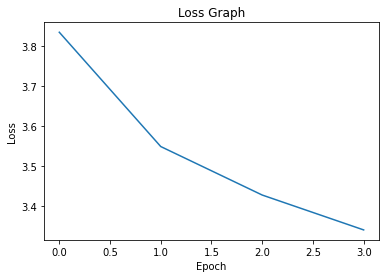

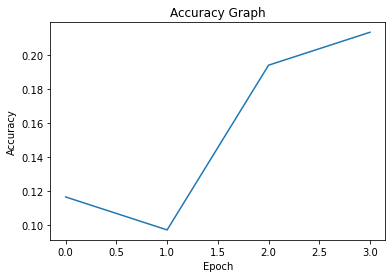

In [24]:
import matplotlib.pyplot as plt
plt.plot(training_loss)
plt.title('Loss Graph')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

plt.plot(training_accuracy)
plt.title('Accuracy Graph')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.show()

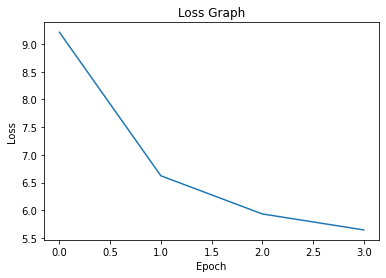

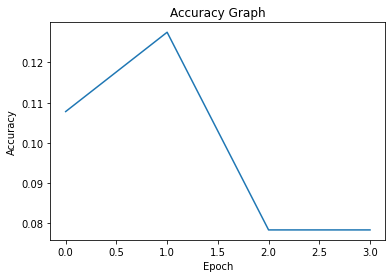

In [25]:
plt.plot(validation_loss)
plt.title('Loss Graph')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

plt.plot(validation_accuracy)
plt.title('Accuracy Graph')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.show()

# 6. Test the model


In [26]:
##---------Type the code below this line------------------##

In [27]:
##---------Type the code below this line------------------##

In [28]:
args = parse_args()
data_transforms_val = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                             std=[0.229, 0.224, 0.225])]) 

In [29]:

model = DAN(num_class=args.num_class, num_head=args.num_head)
from pathlib import Path
checkpoint = torch.load('./datasets/checkpoints/affecnet8_epoch4_acc0.0882.pth')
model.load_state_dict(checkpoint["model_state_dict"])

C:\Users\sudip\anaconda3\envs\tf1\lib\site-packages\torchvision\models\_utils.py:135: UserWarning: Using 'weights' as positional parameter(s) is deprecated since 0.13 and may be removed in the future. Please use keyword parameter(s) instead.
  warnings.warn(
C:\Users\sudip\anaconda3\envs\tf1\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


pretrained True


<All keys matched successfully>

In [30]:
val_dataset = datasets.ImageFolder(f'{args.aff_path}val_set/', transform = data_transforms_val)    # loading statically
if args.num_class == 7:   # ignore the 8-th class 
    idx = [i for i in range(len(val_dataset)) if val_dataset.imgs[i][1] != 7]
    val_dataset = data.Subset(val_dataset, idx)

print('Validation set size:', val_dataset.__len__())

val_loader = torch.utils.data.DataLoader(val_dataset,
                                           batch_size = args.batch_size,
#                                                num_workers = args.workers,
                                         num_workers = 0,
                                           shuffle = False,  
                                           pin_memory = True)

Validation set size: 102


In [31]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [32]:
criterion_cls = torch.nn.CrossEntropyLoss().to(device)
criterion_af = AffinityLoss(device, num_class=args.num_class)
criterion_pt = PartitionLoss()
params = list(model.parameters()) + list(criterion_af.parameters())
optimizer = torch.optim.Adam(params,args.lr,weight_decay = 0)
scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma = 0.6)
best_acc = 0

In [33]:
prediction_loss=[]
prediction_accuracy=[]
for epoch in tqdm(range(1, 4)):
    with torch.no_grad():
                running_loss = 0.0
                iter_cnt = 0
                bingo_cnt = 0
                sample_cnt = 0
                model.eval()
                for imgs, targets in val_loader:

                    imgs = imgs.to(device)
                    targets = targets.to(device)
                    out,feat,heads = model(imgs)

                    loss = criterion_cls(out,targets) + criterion_af(feat,targets) + criterion_pt(heads)

                    running_loss += loss
                    iter_cnt+=1
                    _, predicts = torch.max(out, 1)
                    correct_num  = torch.eq(predicts,targets)
                    bingo_cnt += correct_num.sum().cpu()
                    sample_cnt += out.size(0)

                running_loss = running_loss/iter_cnt   
                scheduler.step()

                acc = bingo_cnt.float()/float(sample_cnt)
                acc = np.around(acc.numpy(),4)
                best_acc = max(acc,best_acc)
                tqdm.write("[Epoch %d] Validation accuracy:%.4f. Loss:%.3f" % (epoch, acc, running_loss))
                tqdm.write("best_acc:" + str(best_acc))
                prediction_loss.append(running_loss.detach().cpu().numpy().tolist())
                prediction_accuracy.append(acc)

  0%|                                                                                            | 0/3 [00:00<?, ?it/s]C:\Users\sudip\anaconda3\envs\tf1\lib\site-packages\torch\optim\lr_scheduler.py:139: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn("Detected call of `lr_scheduler.step()` before `optimizer.step()`. "
 33%|████████████████████████████                                                        | 1/3 [00:05<00:10,  5.02s/it]

out, x, heads tensor([[ 3.0095e+00,  1.7790e+00, -2.9471e+00,  1.5831e+00, -1.2950e+00,
         -4.3177e-01,  2.5445e-01, -1.1796e+00],
        [ 2.3795e+00,  8.1592e-01, -2.4039e-01, -1.6718e-02,  6.4991e-01,
          7.9078e-01, -3.3056e+00, -1.7206e+00],
        [-6.5154e+00, -1.7821e+00, -3.7505e+00, -1.1982e+00, -2.1352e+00,
          1.0139e+00, -1.7818e+00, -7.5548e-02],
        [-8.1649e+00,  1.7131e+00, -1.8675e+00,  4.0225e+00,  1.7511e+00,
         -3.0245e+00, -2.0622e+00, -1.2186e+00],
        [-2.9437e+00, -1.5603e+00, -2.9481e+00,  4.1383e+00, -9.2852e-01,
         -3.2616e+00,  9.3974e-01, -1.2730e+00],
        [ 1.4288e-02, -2.8783e-02, -1.1837e-01, -3.7521e-01, -2.6445e-01,
          1.5195e-01,  1.5357e-01, -1.0567e-01],
        [-2.4476e+00, -4.8926e-01,  6.6584e-02,  1.2581e-01,  1.8929e+00,
         -4.0796e+00, -1.2804e+00,  8.9300e-01],
        [-4.1398e+00, -2.6678e+00,  3.7963e+00,  3.0468e+00, -7.9484e+00,
         -3.9362e+00, -7.6099e+00, -3.7829e+00],
  

 67%|████████████████████████████████████████████████████████                            | 2/3 [00:09<00:04,  4.94s/it]

out, x, heads tensor([[ 3.0095e+00,  1.7790e+00, -2.9471e+00,  1.5831e+00, -1.2950e+00,
         -4.3177e-01,  2.5445e-01, -1.1796e+00],
        [ 2.3795e+00,  8.1592e-01, -2.4039e-01, -1.6718e-02,  6.4991e-01,
          7.9078e-01, -3.3056e+00, -1.7206e+00],
        [-6.5154e+00, -1.7821e+00, -3.7505e+00, -1.1982e+00, -2.1352e+00,
          1.0139e+00, -1.7818e+00, -7.5548e-02],
        [-8.1649e+00,  1.7131e+00, -1.8675e+00,  4.0225e+00,  1.7511e+00,
         -3.0245e+00, -2.0622e+00, -1.2186e+00],
        [-2.9437e+00, -1.5603e+00, -2.9481e+00,  4.1383e+00, -9.2852e-01,
         -3.2616e+00,  9.3974e-01, -1.2730e+00],
        [ 1.4288e-02, -2.8783e-02, -1.1837e-01, -3.7521e-01, -2.6445e-01,
          1.5195e-01,  1.5357e-01, -1.0567e-01],
        [-2.4476e+00, -4.8926e-01,  6.6584e-02,  1.2581e-01,  1.8929e+00,
         -4.0796e+00, -1.2804e+00,  8.9300e-01],
        [-4.1398e+00, -2.6678e+00,  3.7963e+00,  3.0468e+00, -7.9484e+00,
         -3.9362e+00, -7.6099e+00, -3.7829e+00],
  

100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:14<00:00,  4.98s/it]

out, x, heads tensor([[ 3.0095e+00,  1.7790e+00, -2.9471e+00,  1.5831e+00, -1.2950e+00,
         -4.3177e-01,  2.5445e-01, -1.1796e+00],
        [ 2.3795e+00,  8.1592e-01, -2.4039e-01, -1.6718e-02,  6.4991e-01,
          7.9078e-01, -3.3056e+00, -1.7206e+00],
        [-6.5154e+00, -1.7821e+00, -3.7505e+00, -1.1982e+00, -2.1352e+00,
          1.0139e+00, -1.7818e+00, -7.5548e-02],
        [-8.1649e+00,  1.7131e+00, -1.8675e+00,  4.0225e+00,  1.7511e+00,
         -3.0245e+00, -2.0622e+00, -1.2186e+00],
        [-2.9437e+00, -1.5603e+00, -2.9481e+00,  4.1383e+00, -9.2852e-01,
         -3.2616e+00,  9.3974e-01, -1.2730e+00],
        [ 1.4288e-02, -2.8783e-02, -1.1837e-01, -3.7521e-01, -2.6445e-01,
          1.5195e-01,  1.5357e-01, -1.0567e-01],
        [-2.4476e+00, -4.8926e-01,  6.6584e-02,  1.2581e-01,  1.8929e+00,
         -4.0796e+00, -1.2804e+00,  8.9300e-01],
        [-4.1398e+00, -2.6678e+00,  3.7963e+00,  3.0468e+00, -7.9484e+00,
         -3.9362e+00, -7.6099e+00, -3.7829e+00],
  

# 7. Report the result 
3. Report the testing accuracy and loss.
4. Show Confusion Matrix for testing dataset.
5. Report values for preformance study metrics like accuracy, precision, recall, F1 Score.

In [34]:
y_pred = []
y_true = []

for imgs, targets in val_loader:
    imgs = imgs.to(device)
    targets = targets.to(device)
    out,feat,heads = model(imgs)
    _, predicts = torch.max(out, 1)
    correct_num  = torch.eq(predicts,targets)
    bingo_cnt += correct_num.sum().cpu()
    sample_cnt += out.size(0)
    output =(torch.max(out, 1)[1]).data.cpu().numpy()
    y_pred.extend(output) # Save Prediction
    y_true.extend(targets.detach().cpu().numpy().tolist())

out, x, heads tensor([[ 3.0095e+00,  1.7790e+00, -2.9471e+00,  1.5831e+00, -1.2950e+00,
         -4.3177e-01,  2.5445e-01, -1.1796e+00],
        [ 2.3795e+00,  8.1592e-01, -2.4039e-01, -1.6718e-02,  6.4991e-01,
          7.9078e-01, -3.3056e+00, -1.7206e+00],
        [-6.5154e+00, -1.7821e+00, -3.7505e+00, -1.1982e+00, -2.1352e+00,
          1.0139e+00, -1.7818e+00, -7.5548e-02],
        [-8.1649e+00,  1.7131e+00, -1.8675e+00,  4.0225e+00,  1.7511e+00,
         -3.0245e+00, -2.0622e+00, -1.2186e+00],
        [-2.9437e+00, -1.5603e+00, -2.9481e+00,  4.1383e+00, -9.2852e-01,
         -3.2616e+00,  9.3974e-01, -1.2730e+00],
        [ 1.4288e-02, -2.8783e-02, -1.1837e-01, -3.7521e-01, -2.6445e-01,
          1.5195e-01,  1.5357e-01, -1.0567e-01],
        [-2.4476e+00, -4.8926e-01,  6.6584e-02,  1.2581e-01,  1.8929e+00,
         -4.0796e+00, -1.2804e+00,  8.9300e-01],
        [-4.1398e+00, -2.6678e+00,  3.7963e+00,  3.0468e+00, -7.9484e+00,
         -3.9362e+00, -7.6099e+00, -3.7829e+00],
  

In [35]:
from sklearn.metrics import confusion_matrix
import seaborn as sn
# y_pred
# y_true
classes = ('anger', 'contempt', 'disgust', 'fear', 'happy',
        'neutral', 'sad', 'surprise')

In [36]:
cf_matrix = confusion_matrix(y_true, y_pred)
df_cm = pd.DataFrame(cf_matrix / np.sum(cf_matrix, axis=1)[:, None], index = [i for i in classes],
                     columns = [i for i in classes])

<AxesSubplot:>

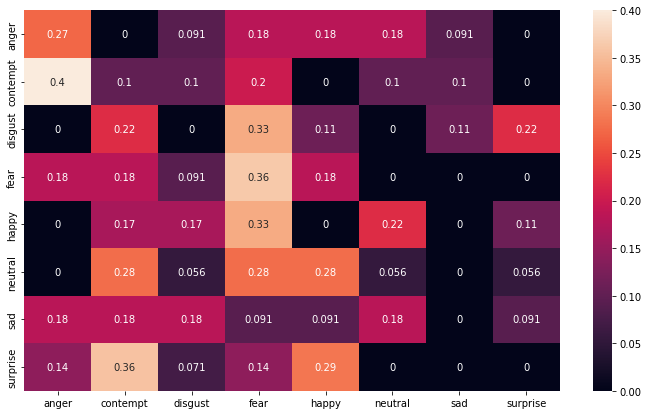

In [37]:
plt.figure(figsize = (12,7))
sn.heatmap(df_cm, annot=True)

In [38]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import cohen_kappa_score
from sklearn.metrics import roc_auc_score

In [39]:
# accuracy: (tp + tn) / (p + n)
accuracy = accuracy_score(y_pred, y_true)
print('Accuracy: %f' ,accuracy)
# precision tp / (tp + fp)
precision = precision_score(y_pred, y_true,pos_label='positive',average='micro')
print('Precision: %f',  precision)
# recall: tp / (tp + fn)
recall = recall_score(y_pred, y_true,pos_label='positive',average='micro')
print('Recall: %f',  recall)
# f1: 2 tp / (2 tp + fp + fn)
f1 = f1_score(y_pred, y_true,pos_label='positive',average='micro')
print('F1 score: %f',  f1)
# auc = roc_auc_score(y_pred, y_true, multi_class='ovr')
# print('ROC AUC: %f',  auc)

Accuracy: %f 0.08823529411764706
Precision: %f 0.08823529411764706
Recall: %f 0.08823529411764706
F1 score: %f 0.08823529411764706


C:\Users\sudip\anaconda3\envs\tf1\lib\site-packages\sklearn\metrics\_classification.py:1379: UserWarning: Note that pos_label (set to 'positive') is ignored when average != 'binary' (got 'micro'). You may use labels=[pos_label] to specify a single positive class.
  warnings.warn(
C:\Users\sudip\anaconda3\envs\tf1\lib\site-packages\sklearn\metrics\_classification.py:1379: UserWarning: Note that pos_label (set to 'positive') is ignored when average != 'binary' (got 'micro'). You may use labels=[pos_label] to specify a single positive class.
  warnings.warn(
C:\Users\sudip\anaconda3\envs\tf1\lib\site-packages\sklearn\metrics\_classification.py:1379: UserWarning: Note that pos_label (set to 'positive') is ignored when average != 'binary' (got 'micro'). You may use labels=[pos_label] to specify a single positive class.
  warnings.warn(


### NOTE


All Late Submissions will incur a <b>penalty of -2 marks </b>. So submit your assignments on time.

Good Luck